In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")

Lagrange (generic function with 1 method)

In [2]:
using LinearAlgebra, DSP, Polynomials

function LagF(t, g, x)
    N = length(t)
    L = zeros(N, N)

    for i in 1:N
        p = [1]
        for j in 1:N
            if i != j
                p = conv(p, [-t[j], 1]) / (t[i] - t[j])
            end
        end
        L[i, :] = p * g[i]
    end

    apprx = sum(L, dims=1)  
    
    poly = Polynomial(apprx[1, :])  # Create a polynomial
    
    
    result = poly(x)  # Evaluate the polynomial at a specific point x
    
    return result
end

LagF (generic function with 1 method)

# IDC-6 Constructed with RK-3 (Predictor and one Corrector are computed using RK-3) method

In [93]:
function idc6_RK3(f, a, b, y0, h, N, p, M, K)
    
    # Inputs: a: tspan[1], b: tspan[2], y0:initial cond, h=dt, N: # of intervals, 
    # Inputs: p= desired order, M : # of subintervals on each group, K: # of corrections,
    
    # RK-3 parameters: 
    
    c2=1/2 
    c3=1 
    a21=1/2 
    a31= -1 
    a32=2
    
    b1=1/6  
    b2=2/3  
    b3=1/6
    
    # IDC
    
    J = N ÷ M # Number of groups (÷ denotes the integer division)
    
    
    y=zeros(1, M+1, K+1)
    t = zeros(M+1)
    t0 = a
    
    for j = 1:J 
        
        t[1] = t0 # t0 gets updated after every group J
        
        # Prediction loop
        
        y[1, 1, 1] = y0 # Initial condition for each group
        
        
        for m = 1:M
            t[m+1] = t[1] + m * h # time increment for each group
            
            k1= h*f(t[m], y[1, m, 1])
            
            k2= h*f(t[m]+ c2*h, y[1, m, 1] + a21*k1)
            
            k3=h*f(t[m]+ c3*h, y[1, m, 1] + a31* k1 + a32*k2)
            
            y[1, m+1, 1]= y[1, m, 1]+ (b1*k1+ b2*k2+ b3*k3) # RK-3 update
            
        end
        
        
        # Correction loop
        
        for k =1:K
            
            y[1, 1, k+1]= y[1, 1, k]
            
            nfval= f(t, y[1, :, k]) # New function value 
            
            for m=1:M
                
                # How to approximate f(t_m+h/2, y(t_m+h/2))?
                
                # Lagrange interpolation !! ? 
                
                yhalf=LagF(t[1:6], nfval[1:6], t[m]+ c2*h) # Approximating f(t_m+c2*h, y(t_m+c2*h))
                
                Q1=Lagrange(t[1:(4*k+2)], nfval[1:(4*k+2)], t[m], t[m]+ c2*h) # Aprroximating the integral
                
                Q2=Lagrange(t[1:(4*k+2)], nfval[1:(4*k+2)], t[m], t[m+1]) # Aprroximating the integral
                
                k1= h*(f(t[m], y[1, m, k+1])-f(t[m], y[1, m, k]))
                
                k2= h*(f(t[m]+ c2*h, y[1, m, k+1] + a21* k1 + Q1) -  yhalf) 
                
                k3= h*(f(t[m]+ c3*h, y[1, m, k+1] + a31* k1 + a32*k2 + Q2) - f(t[m]+ c3*h, y[1, m+1, k]))
                
                #k3= h*(f(t[m]+h, y[1, m, k+1] + 2*k2 - k1 + Q2)- LagF(t[m:m+1], nfval[m:m+1], t[m]+h))
                
                y[1, m+1, k+1] = y[1, m, k+1] + (b1*k1 + b2*k2 + b3*k3) + Q2
                
            end
        end
        
        y0=y[1, M+1, K+1] # storing initial value for the next group (Predictor)
        
        t0 = t[M+1] # updated initial time
        
        
    end
    
    return y 
    
end

idc6_RK3 (generic function with 1 method)

Order p= 2.912354145343922
Order p= 5.827972213444696


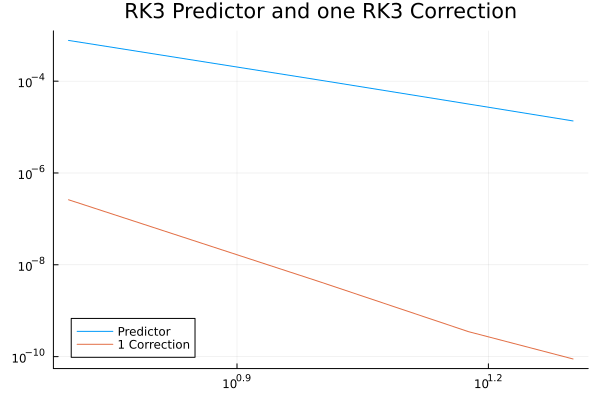

In [94]:
# Convergence Test of IDC using High order intergrators (Uniformly spaced, RK-3 Predictor and Corrector)

a = 0 # Initial time
b = 1 # Terminal time
y0 = 1 # Initial condition
p = 6 # desired order
M = p - 1 # Number of corrections


Nk = 4

err = zeros(p, Nk)
ns = zeros(Nk)

cr=2 # Predictor (1) + # of corrections (1)

for kk in 1:cr
    for n in 1:Nk
        N = 5 * n
        ns[n] = N
        h = (b - a) / N
        #f(t, y)= -2* t .* y .^2
        f(t, y)= y
        #f(t, y)= y.^2
        
        ystore= idc6_RK3(f, a, b, y0, h, N, p, M, kk - 1)

        #exact = 1.0 / 2
        exact= exp(b)
        #exact=2.0
        err[kk, n] = abs(exact - ystore[1, end, kk])
    end
end
# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[1, :]),1)
print("Order p= ",abs(pdeg[2]),"\n") 
plot(ns, err[1, :],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:cr
    plot!(ns, err[j, :],xaxis=:log, yaxis=:log, label="$(j-1) Correction", title="RK3 Predictor and one RK3 Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[j, :]),1)
    print("Order p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))

# IDC7-FE-RK-3

In [83]:
function idc7_FE_RK3(f, a, b, y0, h, N, p, M, K)
    
    # Inputs: a: tspan[1], b: tspan[2], y0:initial cond, h=dt, N: # of intervals, 
    # Inputs: p= desired order, M : # of subintervals on each group, K: # of corrections,
    
    # RK-3 parameters: 
    
    c2=1/2 
    c3=1 
    a21=1/2 
    a31= -1 
    a32=2
    
    b1=1/6  
    b2=2/3  
    b3=1/6
    
    # IDC
    
    J = N ÷ M # Number of groups (÷ denotes the integer division)
    
    
    y=zeros(1, M+1, K+1)
    t = zeros(M+1)
    t0 = a
    
    for j = 1:J 
        
        t[1] = t0 # t0 gets updated after every group J
        
        # Prediction loop
        
        y[1, 1, 1] = y0 # Initial condition for each group
        
        
        for m = 1:M
            t[m+1] = t[1] + m * h # time increment for each group
            
            t[m+1] = t[1] + m * h # time increment for each group
            y[1, m+1, 1]= y[1, m, 1]+ h* f(t[m], y[1, m, 1]) # Forward Euler update
            
        end
        
        
        # Correction loop
        
        for k =1:K
            
            y[1, 1, k+1]= y[1, 1, k]
            
            nfval= f(t, y[1, :, k]) # New function value 
            
            for m=1:M
                
                # How to approximate f(t_m+h/2, y(t_m+h/2))? 
                
                # Lagrange interpolation !!?
                
                
                yhalf=LagF(t[1:(3*k+1)], nfval[1:(3*k+1)], t[m]+ c2*h) # Approximating f(t_m+c2*h, y(t_m+c2*h))
                
                Q1=Lagrange(t[1:(3*k+1)], nfval[1:(3*k+1)], t[m], t[m]+ c2*h) # Aprroximating the integral
                
                Q2=Lagrange(t[1:(3*k+1)], nfval[1:(3*k+1)], t[m], t[m+1]) # Aprroximating the integral
                
                k1= h*(f(t[m], y[1, m, k+1])-f(t[m], y[1, m, k]))
                
                k2= h*(f(t[m]+ c2*h, y[1, m, k+1] + a21* k1 + Q1) -  yhalf) 
                
                k3= h*(f(t[m]+ c3*h, y[1, m, k+1] + a31* k1 + a32*k2 + Q2) - f(t[m]+ c3*h, y[1, m+1, k]))
                
                #k3= h*(f(t[m]+h, y[1, m, k+1] + 2*k2 - k1 + Q2)- LagF(t[m:m+1], nfval[m:m+1], t[m]+h))
                
                y[1, m+1, k+1] = y[1, m, k+1] + (b1*k1 + b2*k2 + b3*k3) + Q2
                
            end
        end
        
        y0=y[1, M+1, K+1] # storing initial value for the next group (Predictor)
        
        t0 = t[M+1] # updated initial time
        
        
    end
    
    return y 
    
end

idc_FE_RK3 (generic function with 1 method)

Order p= 0.9148551692336965
Order p= 3.5019161344754397
Order p= 6.2281037546513724


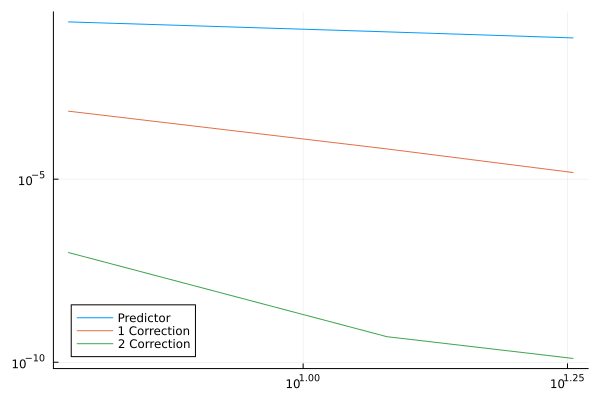

In [90]:
# Convergence Test of IDC using High order intergrators (Uniformly spaced, RK-3 Predictor and Corrector)

a = 0 # Initial time
b = 1 # Terminal time
y0 = 1 # Initial condition
p = 7 # desired order
M = p - 1 # Number of corrections


Nk = 3

err = zeros(p, Nk)
ns = zeros(Nk)

cr=3 # Predictor (1) + # of corrections (1)

for kk in 1:cr
    for n in 1:Nk
        N = 6 * n
        ns[n] = N
        h = (b - a) / N
        #f(t, y)= -2* t .* y .^2
        f(t, y)= y
        #f(t, y)= y.^2
        ystore= idc_FE_RK3(f, a, b, y0, h, N, p, M, kk - 1)

        #exact = 1.0 / 2
        exact= exp(b)
        #exact=2.0
        err[kk, n] = abs(exact - ystore[1, end, kk])
    end
end
# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[1, :]),1)
print("Order p= ",abs(pdeg[2]),"\n") 
plot(ns, err[1, :],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:cr
    plot!(ns, err[j, :],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[j, :]),1)
    print("Order p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))